# A Two-Level, Six-Factor Full Factorial Design

This notebook roughly follows content from Box and Draper's _Empirical Model-Building and Response Surfaces_ (Wiley, 1984). This content is covered by Chapter 4 of Box and Draper.

In this notebook, we'll carry out an anaylsis of a full factorial design, and show how we can obtain inforomation about a system and its responses, and a quantifiable range of certainty about those values. This is the fundamental idea behind empirical model-building and allows us to construct cheap and simple models to represent complex, nonlinear systems.

In [202]:
from IPython.display import Image
Image(url='https://charlesreid1.com/img/empirical.png', width=300)

In [203]:
import pandas as pd
import numpy as np
from numpy.random import rand

# Six-Factor Two-Level Full Factorial Design

Let's start with our six-factor factorial design example. Six factors means there are six input variables; this is still a two-level experiment, so this is now a $2^6$-factorial experiment.

Additionally, there are now three response variables, $(y_1, y_2, y_3)$. 

To generate a table of the 64 experiments to be run at each factor level, we will use the ```itertools.product``` function below. This is all put into a DataFrame.

This example generates some random response data, by multiplying a vector of random numbers by the vector of input variable values. (Nothing too complicated.)

In [204]:
import itertools

# Create the inputs:
encoded_inputs = list( itertools.product([-1,1],[-1,1],[-1,1],[-1,1],[-1,1],[-1,1]) )

# Create the experiment design table:
doe = pd.DataFrame(encoded_inputs,columns=['x%d'%(i+1) for i in range(6)])

In [252]:
#doe['y1'] = doe.apply( lambda z : sum([ rand()*z[i]+0.10*(0.5-rand()) for i in range(1,7) ]), axis=1)
#doe['y2'] = doe.apply( lambda z : sum([ 5*rand()*z[i]+0.10*(0.5-rand()) for i in range(1,7) ]), axis=1)
#doe['y3'] = doe.apply( lambda z : sum([ 10*rand()*z[i]+0.10*(0.5-rand()) for i in range(1,7) ]), axis=1)
#print doe[['y1','y2','y3']][:16]

doe['y1'] = doe.apply( lambda z : sum([ rand()*z["x%d"%(i)]+0.01*(0.5-rand()) for i in range(1,7) ]), axis=1)
doe['y2'] = doe.apply( lambda z : sum([ 5*rand()*z["x%d"%(i)]+0.01*(0.5-rand()) for i in range(1,7) ]), axis=1)
doe['y3'] = doe.apply( lambda z : sum([ 100*rand()*z["x%d"%(i)]+0.01*(0.5-rand()) for i in range(1,7) ]), axis=1)
print doe[['y1','y2','y3']][:16]

          y1         y2          y3
0  -4.296453 -12.264228 -278.849225
1  -2.603677 -15.023589 -184.714699
2  -2.995704 -11.900575  -67.056423
3  -2.423338  -4.803841  -92.252935
4  -3.014573  -6.763401 -264.482335
5  -1.060098  -7.815646   40.210790
6  -1.440225  -0.912540   71.957493
7   1.314391   3.199256   30.340990
8  -1.831907  -2.935746 -212.238769
9  -1.267403  -3.971781  -38.611187
10 -2.771946  -3.939236 -160.354012
11  0.373310   4.256498    6.237213
12 -0.153121  -6.197822 -150.797849
13 -0.067797  -2.017655   18.658509
14  0.640266   2.595577   91.060275
15  1.609418   3.324903  112.365952


Next we'll define some containers for input variable labels, output variable labels, and all of the interaction terms we'll be computing:

In [253]:
labels = {}
labels[1] = ['x1','x2','x3','x4','x5','x6']
for i in [2,3,4,5,6]:
    labels[i] = list(itertools.combinations(labels[1], i))

obs_list = ['y1','y2','y3']

for k in labels.keys():
    print str(k) + " : " + str(labels[k])

1 : ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
2 : [('x1', 'x2'), ('x1', 'x3'), ('x1', 'x4'), ('x1', 'x5'), ('x1', 'x6'), ('x2', 'x3'), ('x2', 'x4'), ('x2', 'x5'), ('x2', 'x6'), ('x3', 'x4'), ('x3', 'x5'), ('x3', 'x6'), ('x4', 'x5'), ('x4', 'x6'), ('x5', 'x6')]
3 : [('x1', 'x2', 'x3'), ('x1', 'x2', 'x4'), ('x1', 'x2', 'x5'), ('x1', 'x2', 'x6'), ('x1', 'x3', 'x4'), ('x1', 'x3', 'x5'), ('x1', 'x3', 'x6'), ('x1', 'x4', 'x5'), ('x1', 'x4', 'x6'), ('x1', 'x5', 'x6'), ('x2', 'x3', 'x4'), ('x2', 'x3', 'x5'), ('x2', 'x3', 'x6'), ('x2', 'x4', 'x5'), ('x2', 'x4', 'x6'), ('x2', 'x5', 'x6'), ('x3', 'x4', 'x5'), ('x3', 'x4', 'x6'), ('x3', 'x5', 'x6'), ('x4', 'x5', 'x6')]
4 : [('x1', 'x2', 'x3', 'x4'), ('x1', 'x2', 'x3', 'x5'), ('x1', 'x2', 'x3', 'x6'), ('x1', 'x2', 'x4', 'x5'), ('x1', 'x2', 'x4', 'x6'), ('x1', 'x2', 'x5', 'x6'), ('x1', 'x3', 'x4', 'x5'), ('x1', 'x3', 'x4', 'x6'), ('x1', 'x3', 'x5', 'x6'), ('x1', 'x4', 'x5', 'x6'), ('x2', 'x3', 'x4', 'x5'), ('x2', 'x3', 'x4', 'x6'), ('x2', 'x3', 'x5', 'x6

Now compute the main and interaction effects. Start with the main effect of each variable, which quantifies the amount the response changes by when the input variable is changed from the -1 to +1 level. That is, it computes the average effect of an input variable $x_i$ on each of the three response variables $y_1, y_2, y_3$.

In [254]:
effects = {}

# Start with the constant effect: this is $\overline{y}$
effects[0] = {'x0' : [doe['y1'].mean(),doe['y2'].mean(),doe['y3'].mean()]}
print effects[0]

{'x0': [-0.049132049505019038, 0.13961112227088224, -0.069607100074165373]}


In [255]:
effects[1] = {}
for key in labels[1]:
    effects_result = []
    for obs in obs_list:
        effects_df = doe.groupby(key)[obs].mean()
        result = sum([ zz*effects_df.ix[zz] for zz in effects_df.index ])
        effects_result.append(result)
    effects[1][key] = effects_result

effects[1]

{'x1': [1.28771354209203, 4.2183533684453156, 75.90398452978954],
 'x2': [1.1745407510181982, 4.6587407836965262, 82.954376349896947],
 'x3': [1.0704323094008119, 4.6046539292639581, 97.195834632254815],
 'x4': [0.89383295250788464, 5.0136625240604298, 89.13439367229347],
 'x5': [1.017596868785577, 5.0126675876140636, 115.33596169618595],
 'x6': [1.1306587043253773, 5.6611592435639597, 123.73911687617482]}

Our next step is to crank through each variable interaction level: two-variable, three-variable, and on up to six-variable interaction effects. We compute interaction effects for each two-variable combination, three-variable combination, etc.

In [256]:
for c in [2,3,4,5,6]:
    effects[c] = {}
    for key in labels[c]:
        effects_result = []
        for obs in obs_list:
            effects_df = doe.groupby(key)[obs].mean()
            result = sum([ np.prod(zz)*effects_df.ix[zz]/(2**(len(zz)-1)) for zz in effects_df.index ])
            effects_result.append(result)
        effects[c][key] = effects_result

In [257]:
def printd(d):
    for k in d.keys():
        print "%25s : %s"%(k,d[k])

for i in range(1,7):
    printd(effects[i])


                       x2 : [1.1745407510181982, 4.6587407836965262, 82.954376349896947]
                       x3 : [1.0704323094008119, 4.6046539292639581, 97.195834632254815]
                       x1 : [1.28771354209203, 4.2183533684453156, 75.90398452978954]
                       x6 : [1.1306587043253773, 5.6611592435639597, 123.73911687617482]
                       x4 : [0.89383295250788464, 5.0136625240604298, 89.13439367229347]
                       x5 : [1.017596868785577, 5.0126675876140636, 115.33596169618595]
             ('x5', 'x6') : [0.21104281378371248, 0.83155485028565446, -39.644708801352337]
             ('x2', 'x4') : [-0.53793955802103166, -0.99786538767044197, -11.405040922904078]
             ('x3', 'x4') : [-0.2192928761270464, -0.68543732112660116, -4.3084203932690244]
             ('x2', 'x6') : [-0.1247984665173465, 0.43329902828510347, -2.5753522830896429]
             ('x1', 'x2') : [0.061911287829729988, 0.45164379953209077, 24.181798575938256]
       

We've computed the main and interaction effects for every variable combination (whew!), but now we're at a point where we want to start doing things with these quantities.

The first and most obvious question: what variable or combination of variables has the strongest effect on $y_1$? $y_2$? $y_3$?

This also raises the specter of incorrect data formatting - what if we chose the wrong format to put our data in? 

Python makes it easy to slice and dice data. In this case, we've constructed a nested dictionary, with the outer keys mapping to numbers of variables and inner keys mapping to particular combinations of input variables. Its pretty easy to convert this to a flat data structure that we can use to sort by variable effects. We've got six "levels" of variable combinations, so we'll flatten ```effects``` by looping through all six dictionaries of variable combinations (from main effects to six-variable interaction effects), and adding each entry to a master dictionary.

The master dictionary will be a flat dictionary, and once we've populated it, we can use it to make a DataFrame for easier sorting, printing, manipulating, aggregating, and so on.

In [258]:
print len(effects)

7


In [259]:
master_dict = {}
for nvars in effects.keys():

    effect = effects[nvars]
    for k in effect.keys():
        v = effect[k]
        master_dict[k] = v

master_df = pd.DataFrame(master_dict).T
master_df.columns = obs_list

y1 = master_df['y1'].copy()
y1.sort_values(inplace=True,ascending=False)

print "Top 10 effects for observable y1:"
print y1[:10]

#print ""
#print "Bottom 10 effects for observable y1:"
#print y1[-10:][::-1]

Top 10 effects for observable y1:
x1                  1.287714
x2                  1.174541
x6                  1.130659
x3                  1.070432
x5                  1.017597
x4                  0.893833
(x1, x2, x3)        0.381570
(x1, x2, x4, x5)    0.319537
(x1, x3, x4, x6)    0.316211
(x1, x3, x5)        0.246390
Name: y1, dtype: float64


In [260]:
y2 = master_df['y2'].copy()
y2.sort_values(inplace=True,ascending=False)

print "Top 10 effects for observable y2:"
print y2[:10]
#print ""
#print "Bottom 10 effects for observable y2:"
#print y2[-10:][::-1]

Top 10 effects for observable y2:
x6                  5.661159
x4                  5.013663
x5                  5.012668
x2                  4.658741
x3                  4.604654
x1                  4.218353
(x1, x3, x4)        1.559923
(x2, x4, x5, x6)    1.540609
(x1, x3)            1.504189
(x1, x4)            1.252670
Name: y2, dtype: float64


In [261]:
y3 = master_df['y3'].copy()
y3.sort_values(inplace=True,ascending=False)

print "Top 10 effects for observable y3:"
print y3[:10]
#print ""
#print "Bottom 10 effects for observable y3:"
#print y3[-10:][::-1]

Top 10 effects for observable y3:
x6                  123.739117
x5                  115.335962
x3                   97.195835
x4                   89.134394
x2                   82.954376
x1                   75.903985
(x2, x4, x5, x6)     43.236888
(x1, x3, x5)         35.941666
(x1, x3)             32.915294
(x1, x2, x4, x5)     28.093945
Name: y3, dtype: float64


The three variables are affected most by:
* $x_2$
* $x_3$
* $x_4$
* $x_5$
* $x_6$

Our very expensive, 64-experiment full factorial design (the data for which maps $(x_1,x_2,\dots,x_6)$ to $(y_1,y_2,y_3)$) gives us 64 data points, and 64 degrees of freedom. 

With these 64 pieces of data, we could fit a 64-coefficient response surface, that accounts for each of the variable interactions whose effects we've computed - from main effects on up to six-variable interaction effects. But this wastes many degrees of freedom, to fit coefficients that aren't that important. Most of the variation in the responses can be explained by a few main effects.

Hence, to describe a model with the 5 variables listed above and no other variable interaction effects would use only 5 degrees of freedom, leaving 59 degrees of freedom available to quantify error, attribute variance, etc.

Our goal is to use least squares to compute model equations for $(y_1,y_2,y_3)$ as functions of $(x_2,x_3,x_4,x_5,x_6)$. 

In [262]:
xlabs = ['x2','x3','x4','x5','x6']
ylabs = ['y1','y2','y3']
ls_data = doe[xlabs+ylabs]

In [263]:
import statsmodels.api as sm
import numpy as np

x = ls_data[xlabs]
x = sm.add_constant(x)

The first ordinary least squares linear model is created to predict values of the first variable, $y_1$, as a function of each of our input variables, the list of which are contained in the ```xlabs``` variable. When we perform the linear regression fitting, we see much of the same information that we found in the prior two-level three-factor full factorial design, but here, everything is done automatically.

The model is linear, meaning it's fitting the coefficients of the function:

$$
\hat{y} = a_0 + a_1 x_1 + a_2 x_2 + a_3 + x_3 + a_4 x_4 + a_5 x_5 + a_6 x_6
$$

Because there are more observations than coefficients, the extra observations give us extra degrees of freedom with which to assess how good the model is. That analysis is done by the OLS object:

In [264]:
y1 = ls_data['y1']
est1 = sm.OLS(y1,x).fit()
print est1.summary()

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     19.24
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           3.08e-11
Time:                        19:14:22   Log-Likelihood:                -85.610
No. Observations:                  64   AIC:                             183.2
Df Residuals:                      58   BIC:                             196.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0491      0.121     -0.406      0.6

In [265]:
y2 = ls_data['y2']
est2 = sm.OLS(y2,x).fit()
print est2.summary()

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     21.90
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           2.99e-12
Time:                        19:14:22   Log-Likelihood:                -180.68
No. Observations:                  64   AIC:                             373.4
Df Residuals:                      58   BIC:                             386.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1396      0.535      0.261      0.7

In [266]:
y3 = ls_data['y3']
est3 = sm.OLS(y3,x).fit()
print est3.summary()

                            OLS Regression Results                            
Dep. Variable:                     y3   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     27.60
Date:                Sat, 10 Dec 2016   Prob (F-statistic):           3.49e-14
Time:                        19:14:23   Log-Likelihood:                -366.75
No. Observations:                  64   AIC:                             745.5
Df Residuals:                      58   BIC:                             758.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0696      9.789     -0.007      0.9

We drastically reduced the cost of our linear model, by reducing 64 terms to 5. The R-squared values given above show that the fit is not very good, but let's start by quantifying the error introduced by reducing the number of variables to see if we're missing anything important.

To do this, we use a quantile-quantile plot to compare our model predictions to data. For each of our 64 experiments, we compute a model prediction $M$ and compare it with data $d$. This results in a residual $r$,

$$
r = \left| d - M \right|
$$

If the model accurately captures the behavior of the underlying data, the error between the model and the data will be purely random, and the residuals will therefore be normally distributed. If there are residuals that are significant outliers, it indicates underlying structure to the residuals and therefore structure that is missed by the model.

When the residuals for each experiment are plotted on a quantile-quantile plot, the points will line up on a straight line if they are normally distributed. Significant deviation by outlier points is indicative of a poor model fit.

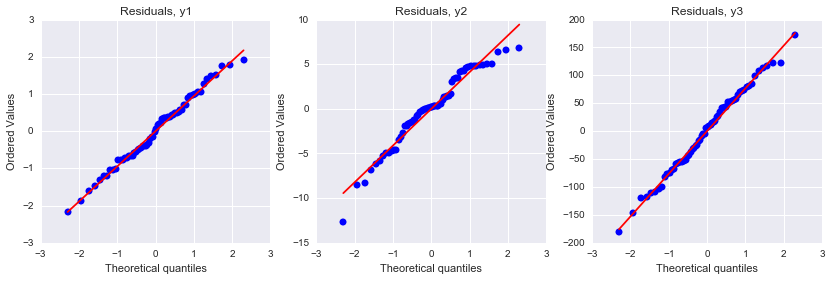

In [267]:
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from matplotlib.pyplot import *

# Quantify goodness of fit

fig = figure(figsize=(14,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

r1 = y1 - est1.predict(x)
r2 = y2 - est2.predict(x)
r3 = y3 - est3.predict(x)

stats.probplot(r1, dist="norm", plot=ax1)
ax1.set_title('Residuals, y1')

stats.probplot(r2, dist="norm", plot=ax2)
ax2.set_title('Residuals, y2')

stats.probplot(r3, dist="norm", plot=ax3)
ax3.set_title('Residuals, y3')

pylab.show()

Determining whether significant trends are being missed by the model depends on how many points deviate from the red line, and how significantly. If there is a single point that deviates, it does not necessarily indicate a problem; but if there is significant wiggle and most points deviate significantly from the red line, it means that there is something about the relationship between the inputs and the outputs that our model is missing.

Another thing we can look at is the normalized error: what are the residual errors (differences between our model prediction and our data)? How are they distributed? A kernel density estimate (KDE) plot, which is a smoothed histogram, shows the probability distribution of the normalized residual errors. As expected, they're bunched pretty close to zero. There are some bumps far from zero, but as we saw from the quantile-quantile plots above, these residuals are distributed the same way normal, random variables are distributed; there's no systematic bias there.

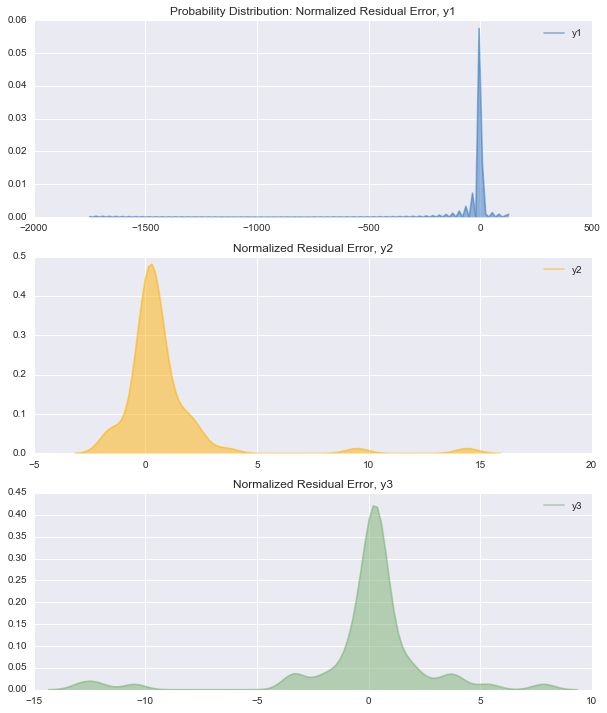

In [268]:
fig = figure(figsize=(10,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
axes = [ax1,ax2,ax3]

colors = sns.xkcd_palette(["windows blue", "amber", "faded green", "dusty purple","aqua blue"])

normed_resids = [r1/y1, r2/y2, r3/y3]

for (dataa, axx, colorr) in zip(normed_resids,axes,colors):
    sns.kdeplot(dataa, bw=0.5, ax=axx, color=colorr, shade=True, alpha=0.5);

ax1.set_title('Probability Distribution: Normalized Residual Error, y1')
ax2.set_title('Normalized Residual Error, y2')
ax3.set_title('Normalized Residual Error, y3')


Box and Draper next report aggregated experiment results, by computing the mean effect for the regressed variables. This is simple to do with Pandas, by grouping the data by each variable, and applying the mean function on all of the results. The code looks like this:

In [269]:
# Our original regression variables
xlabs = ['x2','x3','x4','x5','x6']
doe.groupby(xlabs)[ylabs].mean()

y1         y2          y3
x2 x3 x4 x5 x6                                 
-1 -1 -1 -1 -1 -3.211725 -12.185073 -281.546942
             1 -1.347307 -11.580542 -108.123240
          1 -1 -2.144340 -10.383312 -130.920538
             1 -1.301260  -1.153341  -46.675070
       1 -1 -1 -1.906172  -9.961799 -194.322908
             1 -0.168410  -1.317760   26.940981
          1 -1 -0.635199  -0.951919   -2.349819
             1  1.709336   3.306031   18.389126
    1 -1 -1 -1 -1.195488  -5.354026 -176.132118
             1 -1.261892  -3.660498  -15.469644
          1 -1 -1.059140  -3.156082  -47.106444
             1  0.702842   5.908688   71.441896
       1 -1 -1 -0.269916  -1.300437 -111.674892
             1 -0.081136   3.732592   49.611068
          1 -1  0.308932   4.863133  106.421422
             1  1.678435   8.158197  176.768397
 1 -1 -1 -1 -1 -1.322326  -7.951727 -167.439925
             1  0.004461  -2.205055  -53.287059
          1 -1 -0.605233  -0.133849   37.330240
             1  0.800441   5.494772  -12.448917
       1 -1 -1 -0.688368  -1.556318  -78.084334
             1  0.090828   3.963231   64.279217
          1 -1  0.104396   1.993835   -4.411368
             1  1.271307  10.019373  153.990164
    1 -1 -1 -1  0.167001   0.695130 -133.357948
             1  0.708517   3.714168  128.393088
          1 -1  1.268110   0.243256   83.529775
             1  1.860563   3.831968  137.623985
       1 -1 -1  0.285086  -0.637949   27.123060
             1  1.269959   7.738500   99.290188
          1 -1  1.073000   2.721641   81.916091
             1  2.322472  11.572728  298.075041

In [270]:
# If we decided to go for a smaller variable set
xlabs = ['x2','x3','x4','x6']
doe.groupby(xlabs)[ylabs].mean()

y1         y2          y3
x2 x3 x4 x6                                 
-1 -1 -1 -1 -2.678033 -11.284192 -206.233740
          1 -1.324283  -6.366941  -77.399155
       1 -1 -1.270686  -5.456859  -98.336363
          1  0.770463   0.994135   22.665054
    1 -1 -1 -1.127314  -4.255054 -111.619281
          1 -0.279525   1.124095   27.986126
       1 -1  0.019508   1.781348   -2.626735
          1  0.798650   5.945395  113.189733
 1 -1 -1 -1 -0.963780  -4.042788  -65.054843
          1  0.402451   1.644858  -32.867988
       1 -1 -0.291986   0.218758  -41.247851
          1  0.681067   6.991302  109.134691
    1 -1 -1  0.717555   0.469193  -24.914087
          1  1.284540   3.773068  133.008536
       1 -1  0.679043   1.041846   54.519575
          1  1.796216   9.655614  198.682614

This functionality can also be used to determine the variance in all of the experimental observations being aggregated:

In [271]:
doe.groupby(xlabs)[ylabs].var()

y1         y2            y3
x2 x3 x4 x6                                   
-1 -1 -1 -1  1.647406   2.621017  10286.706366
          1  1.892391  53.029322   6554.354734
       1 -1  1.789536  33.880178  19247.170234
          1  1.809370  35.282430    237.001319
    1 -1 -1  2.232020   5.917924  14968.342789
          1  1.359141  32.407526   5709.326334
       1 -1  0.193971  32.080652  17033.047766
          1  1.035325  44.146043   8793.486031
 1 -1 -1 -1  0.900287  25.364444  16084.836602
          1  1.052776  40.608948   1186.630860
       1 -1  0.713900  13.933349  14112.155115
          1  1.074363  14.009245   4782.994299
    1 -1 -1  2.310793  17.685696  24393.965427
          1  0.827468  17.390114  10640.300108
       1 -1  1.022107  54.849564  12781.684398
          1  0.908887  21.105068  14551.982529

Or even the number of experimental observations being aggregated!

In [272]:
doe.groupby(xlabs)[ylabs].count()

y1  y2  y3
x2 x3 x4 x6            
-1 -1 -1 -1   4   4   4
          1   4   4   4
       1 -1   4   4   4
          1   4   4   4
    1 -1 -1   4   4   4
          1   4   4   4
       1 -1   4   4   4
          1   4   4   4
 1 -1 -1 -1   4   4   4
          1   4   4   4
       1 -1   4   4   4
          1   4   4   4
    1 -1 -1   4   4   4
          1   4   4   4
       1 -1   4   4   4
          1   4   4   4

We can convert these dataframes of averages, variances, and counts into data for plotting. For example, if we want to make a histogram of every value in the groupby dataframe, we can use the ```.values``` method, so that this:

    doe.gorupby(xlabs)[ylabs].mean()

becomes this:


    doe.groupby(xlabs)[ylabs].mean().values


This $M \times N$ array can then be flattened into a vector using the ```ravel()``` method from numpy:

    np.ravel( doe.groupby(xlabs)[ylabs].mean().values )

The resulting data can be used to generate histograms, as shown below:

Grouping responses by interaction x2-x3-x4-x6


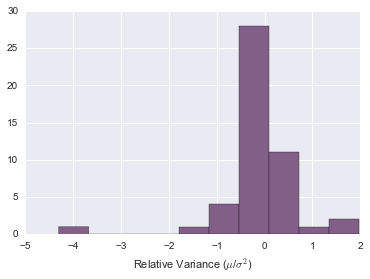

In [273]:
# Histogram of means of response values, grouped by xlabs

print "Grouping responses by interaction %s"%( "-".join(xlabs) )
dat = np.ravel(doe.groupby(xlabs)[ylabs].mean().values) / np.ravel(doe.groupby(xlabs)[ylabs].var().values)
plt.hist(dat, 10, normed=False, color=colors[3]);
plt.xlabel(r'Relative Variance ($\mu$/$\sigma^2$)')

Grouping responses by interaction x2-x3-x4-x6


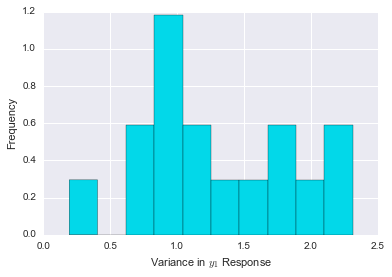

In [274]:
# Histogram of variances of response values, grouped by xlabs

print "Grouping responses by interaction %s"%( "-".join(xlabs) )
dat = np.ravel(doe.groupby(xlabs)['y1'].var().values)
plt.hist(dat, normed=True, color=colors[4]);
plt.xlabel(r'Variance in $y_{1}$ Response');
plt.ylabel(r'Frequency');